In [26]:
#%matplotlib inline

import pandas as pd
import numpy as np

import xarray as xr

import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import feather, h5py, sys, pickle
from shapely.geometry import Point, Polygon
from geocube.api.core import make_geocube
import xagg as xa
import netCDF4
import geopandas
import feather 

import sys
sys.path.append('../')
import utils
import plotting

import difflib 

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [28]:
#import dataset
ds = xr.open_dataset('./final_data/ds_PM_O3_daily_counties.nc4')


In [33]:
states = geopandas.read_file('data/cb_2018_us_state_500k.shx')


In [34]:
#convert to county name as coordinate/dim
ds['pix_idx'] = ds['CountyName']
ds = ds.rename({'pix_idx':'county'})

In [35]:
#convert from statefp to statename
states = geopandas.read_file('data/cb_2018_us_state_500k.shx')
states['STATEFP'] = states['STATEFP'].astype('float64')
state_dict = dict(states.groupby("STATEFP").first()['NAME'])
state_list = [state_dict[i] for i in ds['STATEFP'].values]
ds['STATEFP'] = xr.DataArray(data = state_list, dims = 'county', coords = dict(county = ('county', ds.county)))
ds = ds.rename({"STATEFP":'state'})

In [36]:
gen = feather.read_dataframe(f'../optimization_model/outputs/gen_normal.feather')
carac = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_normal.csv')
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
# Clean columns name
carac = carac.drop('Unnamed: 0', axis=1)

# Merge
df_normal = pd.concat((carac,gen), axis=1)
df_normal['2016_365_23'] = df_normal['2016_365_22'].copy()

col_list = list(gen.columns)
col_list.append('2016_365_23')
df_normal['total_gen'] = df_normal[col_list].sum(axis=1)
df_normal.loc[df_normal['CountyName'] == 'La Salle','CountyName'] = 'LaSalle'
df_normal.loc[df_normal['CountyName'] == 'WestChester','CountyName'] = 'Westchester'
df_normal.loc[df_normal['CountyName'] == 'Apache', 'StateName'] = 'Arizona'
df_normal.loc[df_normal['CountyName'] == 'Dona Ana','CountyName'] = 'Doña Ana'
df_normal.loc[df_normal['CountyName'] == 'St Charles','CountyName'] = 'St. Charles'
df_normal.loc[df_normal['CountyName'] == 'St Clair','CountyName'] = 'St. Clair'

df_normal['CountyName'] = df_normal['CountyName'].str.lower()
df_normal['StateName'] = df_normal['StateName'].str.lower()


In [57]:
ds['state'] = ds['state'].str.lower()

In [58]:
ds['county'] = ds['county'].str.lower()

In [61]:
for ssn in ['DJF','JJA']:
    for poll in ['PM25','O3']:
        df_normal[f'{ssn}_{poll}_delta'] = np.nan
        for i in range(0,len((df_normal).groupby(['CountyName','StateName']).first())):
            state_name =  (df_normal).groupby(['CountyName','StateName']).first().index[i][1]
            county_name = (df_normal).groupby(['CountyName','StateName']).first().index[i][0]
            p_change = (utils.season_mean(ds.where(ds.state == state_name,
          drop = True).sel(
    county = ds.where(ds.state == state_name,drop = True).county.isin(county_name))[poll]).sel(
    model_name = 'nonuc_NA', season = ssn) - 
                  utils.season_mean(ds.where(ds.state == state_name,
          drop = True).sel(
    county = ds.where(ds.state == state_name,drop = True).county.isin(county_name))[poll]).sel(
    model_name = 'normal_NA', season = ssn)
                       ).mean().values
            
            df_normal.loc[(df_normal['CountyName'] == county_name) & (df_normal['StateName'] == state_name),f'{ssn}_{poll}_delta'] = p_change.squeeze()
        print(poll)
    print(ssn)

PM25
O3
DJF


KeyboardInterrupt: 

In [ ]:
df_normal.to_csv('./final_data/county_avg.csv')

# Analysis

In [5]:
df = pd.read_csv('./data/county_avg.csv')

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#import dataset
ds = xr.open_zarr('data/GC_counties.zarr/')
#convert to county name as coordinate/dim
ds['pix_idx'] = ds['CountyName']
ds = ds.rename({'pix_idx':'county'})

#convert from statefp to statename
states = geopandas.read_file('data/cb_2018_us_state_500k.shx')
states['STATEFP'] = states['STATEFP'].astype('float64')
state_dict = dict(states.groupby("STATEFP").first()['NAME'])
state_list = [state_dict[i] for i in ds['STATEFP'].values]
ds['STATEFP'] = xr.DataArray(data = state_list, dims = 'county', coords = dict(county = ('county', ds.county)))
ds = ds.rename({"STATEFP":'state'})

In [7]:
PM_df = xr.Dataset.to_dataframe(xr.merge([ds['state'], ds.drop('ilev').mean(dim = 'time')['PM25']]))

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [8]:
O3_df = xr.Dataset.to_dataframe(xr.merge([ds['state'], ds.drop('ilev').groupby('time.season').mean(dim = 'time').sel(season = 'JJA')['O3']]))
O3_df.drop(columns = 'state', inplace = True)

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [9]:
poll_df = pd.concat([O3_df,PM_df],axis=1)

Mortality data from: https://wonder.cdc.gov/controller/datarequest/D140;jsessionid=3706D5550499EA883D9361BB7FC6
Centers for Disease Control and Prevention, National Center for Health Statistics. Compressed Mortality File 1999-2016 on CDC WONDER Online Database, released June 2017. Data are from the Compressed Mortality File 1999-2016 Series 20 No. 2U, 2016, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/cmf-icd10.html on Jul 13, 2021 2:41:50 PM

In [10]:
mort_df = pd.read_excel('data/compressed_mortality_cdc.xlsx')
mort_df = mort_df.drop(columns = 'Notes')
mort_df.dropna(inplace = True)

In [11]:
mort_df2 = pd.read_excel('./data/compressed_mortality_cdc_hispanic.xlsx')
mort_df2 = mort_df2.drop(columns = {'Notes'})
mort_df2.dropna(inplace = True)

In [12]:
mort_df.rename(columns = {'Race':'Race/Hispanic Origin'}, inplace = True)
mort_df2.rename(columns = {'Hispanic Origin':'Race/Hispanic Origin'}, inplace = True)

In [13]:
mort_df = pd.concat([mort_df, mort_df2])
mort_df.loc[mort_df['Population'] == 'Not Applicable','Population'] = np.nan

## Beta calculations for PM

In [14]:
#beta from Vodonos et al. 2018
beta_orig_df = pd.read_csv('data/CRF_Vodonos_data.csv', names = ['PM25','beta'])
zero_row = pd.DataFrame({'beta':beta_orig_df['beta'][0], 'PM25':0}, index = {0})
beta_orig_df = pd.concat([zero_row, beta_orig_df]).set_index('PM25')


In [15]:
β_df = pd.DataFrame()
β_df['beta'] = np.interp(np.arange(0,70,.0001), list(beta_orig_df.index), beta_orig_df['beta'])/100.
β_df['PM25'] = np.arange(0,70,.0001)
β_df = β_df.set_index('PM25')
β_df['Δx'] = np.insert(np.diff(β_df.index), 0, np.nan)

In [16]:
x0 = poll_df.xs('normal_model', level = 1)
x1 = poll_df.xs('nonuc_model', level = 1)
x0 = x0.rename(columns = {'PM25':'normal_PM25', 'O3':'normal_O3'})
x1 = x1.rename(columns = {'PM25':'nonuc_PM25', 'O3':'nonuc_O3'})


In [17]:
x0 = x0.groupby(['county','state']).mean()
x1 = x1.groupby(['county','state']).mean()

In [18]:
poll_df = pd.concat([x0, x1], axis=1)

In [19]:
def β_mean(x_norm, x_nonuc):
    if (x_norm==x_nonuc):
        return β_df.iloc[β_df.index.get_loc(x_norm, method='nearest')]['beta']
    if np.isnan(x_norm) | np.isnan(x_nonuc):
        return(np.nan)
    if x_nonuc>x_norm:
        return((1/(x_nonuc-x_norm))*np.sum((β_df['beta']*β_df['Δx']).iloc[β_df.index.get_loc(x_norm, method='nearest'):β_df.index.get_loc(x_nonuc, method='nearest')]))
    if x_norm>x_nonuc:
        return((1/(x_norm-x_nonuc))*np.sum((β_df['beta']*β_df['Δx']).iloc[β_df.index.get_loc(x_nonuc, method='nearest'):β_df.index.get_loc(x_norm, method='nearest')]))


In [20]:
def apply_β(df):
    return pd.Series([
    β_mean(x_norm, x_nonuc)
    for (x_norm, x_nonuc) in zip(poll_df['normal_PM25'], poll_df['nonuc_PM25'])
  ])

In [21]:
a = apply_β(poll_df)
poll_df = poll_df.reset_index()
poll_df['βm_PM'] = a
poll_df['AF_PM'] = (np.exp(poll_df['βm_PM']*(poll_df['nonuc_PM25'] - poll_df['normal_PM25']))-1)/np.exp(poll_df['βm_PM']*(poll_df['nonuc_PM25'] - poll_df['normal_PM25']))

## Dataframe modifications

In [22]:
mort_df['County'] = mort_df['County'].astype('string')
mort_df[['county','state']] = mort_df['County'].str.split(', ',expand=True)

In [23]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [24]:
mort_df['state'] = mort_df['state'].map(lambda x: x.replace(" ", ""))
state_list = [states[i] for i in mort_df['state'].values]
mort_df['state'] = state_list

In [25]:
poll_df['county'] = poll_df['county']
mort_df['county'] = mort_df['county'].str.replace(' Parish', '')
mort_df['county'] = mort_df['county'].str.replace(' County', '')
mort_df['county'] = mort_df['county'].str.replace(' city', '')
mort_df.loc[(mort_df['county'] == 'Shannon') & (mort_df['state'] == 'South Dakota'), 'county'] = 'Oglala Lakota'

In [26]:
#drop non-contiguous US states
poll_df.drop(index = poll_df.loc[poll_df['state'].isin(['American Samoa', 'Alaska','Hawaii', 'Commonwealth of the Northern Mariana Islands', 'Guam', 'Puerto Rico', 'United States Virgin Islands'])].index, inplace = True)
mort_df.drop(index = mort_df.loc[mort_df['state'].isin(['Alaska', 'Hawaii'])].index, inplace = True)

In [27]:
#map our counties together matching the names
poll_df['county_new'] = poll_df['county'].map(lambda x: difflib.get_close_matches(x, mort_df['county'], n = 1, cutoff = .8))

In [28]:
#Reset indices to drop unmatched columns-- mortality data doesn't exist for many locations due to small numbers
poll_df['index_new'] = range(0, len(poll_df))
poll_df.reset_index(inplace = True)
poll_df.set_index(poll_df['index_new'], inplace = True)
poll_df.drop(columns = {'index','index_new'}, inplace = True)
indices = [84, 202, 234, 357, 1341, 1462, 1477, 1695, 1844, 2211, 2587, 2671, 2686, 2782, 3101]
poll_df.drop(index = indices, inplace = True)

In [29]:
#change county names so that they are no longer in list format
for i in poll_df.index:
    poll_df.loc[i, 'county_new'] = poll_df.loc[i, 'county_new'][0]

In [30]:
#find dif between two lists:
for county in list(set(mort_df['county']).difference(poll_df['county_new'])):
    print(county, poll_df.loc[poll_df['county_new'] == county]['county_new'].values)
    
mort_df.loc[mort_df['county'] == 'De Kalb','county'] = 'DeKalb'
poll_df.rename(columns = {'county':'county_old','county_new':'county'}, inplace = True)

Ziebach []
De Kalb []


In [31]:
mort_df['Population'] = mort_df['Population'].astype(float)
#join our two dataframes
full_df = mort_df.groupby(['county','state','Race/Hispanic Origin']).mean().join(poll_df.groupby(['county','state']).mean(), on=['county','state'])
#check that there are no nans
full_df[full_df.isna().any(axis=1)]

,,,County Code,Deaths,Population,normal_O3,normal_PM25,nonuc_O3,nonuc_PM25,βm_PM,AF_PM
county,state,Race/Hispanic Origin,,,,,,,,,
Adams,Colorado,Not Stated,8001.0,10.0,NaN,54.472876,4.080975,54.377724,3.958023,0.016381,-0.002016
Alameda,California,Not Stated,6001.0,15.0,NaN,34.782335,7.208841,34.695889,7.169475,0.014971,-0.000590
Allegheny,Pennsylvania,Not Stated,42003.0,148.0,NaN,47.461162,11.332772,47.773900,11.877048,0.012941,0.007019
Baltimore,Maryland,Not Stated,24510.0,17.0,NaN,50.634508,10.883586,51.559572,11.198502,0.013198,0.004148
Barnstable,Massachusetts,Not Stated,25001.0,94.0,NaN,45.281481,6.379121,45.594296,6.424027,0.015358,0.000689
...,...,...,...,...,...,...,...,...,...,...,...
Westchester,New York,Not Stated,36119.0,61.0,NaN,45.266123,10.506808,45.494553,10.631142,0.013390,0.001663
Westmoreland,Pennsylvania,Not Stated,42129.0,32.0,NaN,47.591889,9.984390,46.799919,10.504574,0.013535,0.007016
Worcester,Massachusetts,Not Stated,25027.0,360.0,NaN,39.983288,8.409694,40.303291,8.475393,0.014392,0.000945


In [32]:
full_df['mortality_0'] = full_df['Deaths']/full_df['Population']
full_df['Δmortality_PM'] = full_df['AF_PM'] * full_df['Population'] * full_df['mortality_0']

# Calculations for Ozone

(hazard ratio [HR] per 10 ppb, 1.02; 95% confidence interval [CI], 1.01–1.04) from Turner 2016 (which is used in the latest regulatory impact analysis for CSAPR https://www.epa.gov/sites/production/files/2021-03/documents/revised_csapr_update_ria_final.pdf) 

ΔM≃β_LL×I_OBS×(Δχ×p_aff )   

In [34]:
#bootstrap function    
def draw_bs(x, size):
    #Perform pairs bootstrap for linear regression

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Generate replicates
    bs_inds = np.random.choice(inds, size=size)
    bs_val= x[bs_inds]
        
    return bs_val

In [35]:
delta_chi = 10 #ppb
RR = 1.02 #
β = np.log(RR)/delta_chi
CI_min = 1.01
sd = (β-(np.log(CI_min)/delta_chi))/2
draws = 1000
#create normal distribution around our beta
β_normal_dist = np.random.normal(β, sd, draws)


In [36]:
full_df['Δmortality_O3'] = (full_df['nonuc_O3'] - full_df['normal_O3'] ) * full_df['Population'] * full_df['mortality_0'] * draw_bs(β_normal_dist, size=1000).mean()

In [37]:
full_df['Δmortality_O3'].sum()

4137.726116412966

# Analysis

In [38]:
for race in np.unique(mort_df['Race/Hispanic Origin']):
    for poll in ['O3','PM']:
        print(race, poll, 1e5*full_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum()/full_df.xs(race, level = 2)['Population'].sum(), 'per 100,000')
for race in np.unique(mort_df['Race/Hispanic Origin']):
    for poll in ['O3','PM']:
        print('Total mortalities', race, poll, full_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum())

American Indian or Alaska Native O3 0.0981685915221893 per 100,000
American Indian or Alaska Native PM -0.1766050044705393 per 100,000
Asian or Pacific Islander O3 0.07152064403899523 per 100,000
Asian or Pacific Islander PM 0.042458025679373144 per 100,000
Black or African American O3 0.7660251358859734 per 100,000
Black or African American PM 1.5728973378742868 per 100,000
Hispanic or Latino O3 0.04933032054554193 per 100,000
Hispanic or Latino PM -0.120686558346424 per 100,000
Not Hispanic or Latino O3 0.7865792478566037 per 100,000
Not Hispanic or Latino PM 1.7331963430175363 per 100,000
Not Stated O3 nan per 100,000
Not Stated PM nan per 100,000
White O3 0.6945728794662013 per 100,000
White PM 1.5247904991886891 per 100,000
Total mortalities American Indian or Alaska Native O3 3.0399082387944185
Total mortalities American Indian or Alaska Native PM -5.4687858894356145
Total mortalities Asian or Pacific Islander O3 12.85282260127603
Total mortalities Asian or Pacific Islander PM 7.

### Separate nuclear and no nuclear locations

In [40]:
#remove counties from list that do not have mortality data
df.drop(df.loc[(df['CountyName'] == 'borden') & (df['StateName'] == 'texas')].index, inplace = True)
df.drop(df.loc[(df['CountyName'] == 'clark') & (df['StateName'] == 'idaho')].index, inplace = True)
df.drop(df.loc[(df['CountyName'] == 'glasscock') & (df['StateName'] == 'texas')].index, inplace = True)
df.drop(df.loc[(df['CountyName'] == 'kenedy') & (df['StateName'] == 'texas')].index, inplace = True)
df.drop(df.loc[(df['CountyName'] == 'kent') & (df['StateName'] == 'texas')].index, inplace = True)
df.drop(df.loc[(df['CountyName'] == 'keya paha') & (df['StateName'] == 'nebraska')].index, inplace = True)
df.drop(df.loc[(df['CountyName'] == 'roberts') & (df['StateName'] == 'texas')].index, inplace = True)

In [41]:
#rename counties to match both dataframes
df.loc[df['CountyName'] == 'doña ana', 'CountyName'] = 'dona ana' 
df.loc[df['CountyName'] == 'laporte', 'CountyName'] = 'la porte' 

In [42]:
state_county_nuc = list(df.loc[df['FuelType'] == 'Nuclear'][['CountyName','StateName']].drop_duplicates().itertuples(index=False, name=None))
state_county_nonuc = list(df.groupby(['CountyName','StateName']).first().drop(state_county_nuc).reset_index()[['CountyName','StateName']].drop_duplicates().itertuples(index=False, name=None))

In [49]:
#nuclear df
nuclear_df = full_df.reset_index()
nuclear_df['county'] = nuclear_df['county'].str.lower()
nuclear_df['state'] = nuclear_df['state'].str.lower()
nuclear_df = nuclear_df.set_index(['county','state']).loc[state_county_nuc].reset_index().set_index(['county','state','Race/Hispanic Origin'])
#no nuclear df
no_nuclear_df = full_df.reset_index()
no_nuclear_df['county'] = no_nuclear_df['county'].str.lower()
no_nuclear_df['state'] = no_nuclear_df['state'].str.lower()
no_nuclear_df = no_nuclear_df.set_index(['county','state']).loc[state_county_nonuc].reset_index().set_index(['county','state','Race/Hispanic Origin'])

### Separate coal and no coal counties

In [44]:
state_county_coal = list(df.loc[df['FuelType'] == 'Coal'][['CountyName','StateName']].drop_duplicates().itertuples(index=False, name=None))
state_county_nocoal = list(df.groupby(['CountyName','StateName']).first().drop(state_county_coal).reset_index()[['CountyName','StateName']].drop_duplicates().itertuples(index=False, name=None))

In [46]:
#nuclear df
coal_df = full_df.reset_index()
coal_df['county'] = coal_df['county'].str.lower()
coal_df['state'] = coal_df['state'].str.lower()
coal_df = coal_df.set_index(['county','state']).loc[state_county_coal].reset_index().set_index(['county','state','Race/Hispanic Origin'])
#no nuclear df
no_coal_df = full_df.reset_index()
no_coal_df['county'] = no_coal_df['county'].str.lower()
no_coal_df['state'] = no_coal_df['state'].str.lower()
no_coal_df = no_coal_df.set_index(['county','state']).loc[state_county_nocoal].reset_index().set_index(['county','state','Race/Hispanic Origin'])

### Separate ng and no ng counties

In [47]:
state_county_natgas = list(df.loc[df['FuelType'] == 'Coal'][['CountyName','StateName']].drop_duplicates().itertuples(index=False, name=None))
state_county_nonatgas = list(df.groupby(['CountyName','StateName']).first().drop(state_county_natgas).reset_index()[['CountyName','StateName']].drop_duplicates().itertuples(index=False, name=None))

In [48]:
#nuclear df
natgas_df = full_df.reset_index()
natgas_df['county'] = natgas_df['county'].str.lower()
natgas_df['state'] = natgas_df['state'].str.lower()
natgas_df = natgas_df.set_index(['county','state']).loc[state_county_natgas].reset_index().set_index(['county','state','Race/Hispanic Origin'])
#no nuclear df
no_natgas_df = full_df.reset_index()
no_natgas_df['county'] = no_natgas_df['county'].str.lower()
no_natgas_df['state'] = no_natgas_df['state'].str.lower()
no_natgas_df = no_natgas_df.set_index(['county','state']).loc[state_county_nonatgas].reset_index().set_index(['county','state','Race/Hispanic Origin'])

### Analyze county makeup

In [118]:
full_df.reset_index(inplace = True)
full_df['county'] = full_df['county'].str.lower()
full_df['state'] = full_df['state'].str.lower()
full_df.set_index(['county','state','Race/Hispanic Origin'], inplace = True)

In [131]:
nuclear_df.xs(race, level = 2)[f'nonuc_{poll}'].xs(state, level = 1) - nuclear_df.xs(race, level = 2)[f'normal_{poll}'].xs(state, level = 1)

county
manitowoc    0.148757
dtype: float64

In [137]:
no_nuclear_df.xs(race, level = 2)[f'nonuc_{poll}'].groupby('state').mean().loc[state] - no_nuclear_df.xs(race, level = 2)[f'normal_{poll}'].groupby('state').mean().loc[state]

0.15953107224661522

In [136]:
full_df.xs(race, level = 2)[f'nonuc_{poll}'].groupby('state').mean().loc[state] - full_df.xs(race, level = 2)[f'normal_{poll}'].groupby('state').mean().loc[state]

0.15396898455696828

In [143]:
for race in np.unique(mort_df['Race/Hispanic Origin']):
    for poll in ['PM25','O3']:
        for state in nuclear_df.xs(race, level = 2)[f'nonuc_{poll}'].groupby('state').sum().index:
            print(race, poll, state, 100*((nuclear_df.xs(race, level = 2)[f'nonuc_{poll}'].xs(state, level = 1) - 
                   nuclear_df.xs(race, level = 2)[f'normal_{poll}'].xs(state, level = 1))
                  /(no_nuclear_df.xs(race, level = 2)[f'nonuc_{poll}'].groupby('state').mean().loc[state] -
                   no_nuclear_df.xs(race, level = 2)[f'normal_{poll}'].groupby('state').mean().loc[state])).values)

American Indian or Alaska Native PM25 arizona [101.61749324]
American Indian or Alaska Native PM25 california [79.00550659]
American Indian or Alaska Native PM25 florida [-2307.22561359]
American Indian or Alaska Native PM25 michigan [146.37932362 151.38237863]
American Indian or Alaska Native PM25 north carolina [ 98.34581437 108.3996364 ]
American Indian or Alaska Native PM25 south carolina [99.12941767]
American Indian or Alaska Native PM25 washington [120.92345119]
American Indian or Alaska Native O3 arizona [88.16873249]
American Indian or Alaska Native O3 california [79.6612557]
American Indian or Alaska Native O3 florida [-25.44266106]
American Indian or Alaska Native O3 michigan [234.16243448 229.06518101]
American Indian or Alaska Native O3 north carolina [111.65261739 108.29152092]
American Indian or Alaska Native O3 south carolina [119.67563643]
American Indian or Alaska Native O3 washington [-40.92004868]
Asian or Pacific Islander PM25 arizona [98.57414284]
Asian or Pacific

county
somervell    0.043059
matagorda   -0.064816
Name: Δmortality_PM, dtype: float64

In [ ]:
nuclear_df.xs((state for state in (nuclear_df.xs(race, level = 2).reset_index()['state'])), level = 1).xs(race, level = 1)[f'Δmortality_{poll}'].sum()

In [92]:
nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}']/nuclear_df.xs([s for s in (nuclear_df.xs(race, level = 2).reset_index()['state']).values], level = 1).xs(race, level = 1)[f'Δmortality_{poll}'].sum()

/tmp/ipykernel_47523/409362588.py:1: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}']/nuclear_df.xs([s for s in (nuclear_df.xs(race, level = 2).reset_index()['state']).values], level = 1).xs(race, level = 1)[f'Δmortality_{poll}'].sum()


KeyError: ('texas', 'texas', 'florida', 'iowa', 'illinois', 'michigan', 'michigan', 'minnesota', 'minnesota', 'missouri', 'wisconsin', 'massachusetts', 'new hampshire', 'connecticut', 'new york', 'new york', 'new york', 'ohio', 'ohio', 'illinois', 'illinois', 'illinois', 'illinois', 'illinois', 'virginia', 'virginia', 'new jersey', 'new jersey', 'pennsylvania', 'pennsylvania', 'maryland', 'pennsylvania', 'pennsylvania', 'michigan', 'pennsylvania', 'kansas', 'nebraska', 'nebraska', 'tennessee', 'tennessee', 'louisiana', 'arkansas', 'mississippi', 'louisiana', 'georgia', 'alabama', 'georgia', 'south carolina', 'south carolina', 'south carolina', 'north carolina', 'north carolina', 'south carolina', 'north carolina', 'arizona', 'washington', 'california')

In [43]:
for race in np.unique(mort_df['Race/Hispanic Origin']):
    for poll in ['O3','PM']:
        print(race, poll, 1e5*nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum()/nuclear_df.xs(race, level = 2)['Population'].sum(), 'per 100,000')
for race in np.unique(mort_df['Race/Hispanic Origin']):
    for poll in ['O3','PM']:
        print('Total mortalities', race, poll, nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum())

American Indian or Alaska Native O3 -0.06326709691102285 per 100,000
American Indian or Alaska Native PM -0.7215217957406924 per 100,000
Asian or Pacific Islander O3 0.14397412685415895 per 100,000
Asian or Pacific Islander PM 0.1692593800674097 per 100,000
Black or African American O3 0.5993688488283877 per 100,000
Black or African American PM 1.0920448285688586 per 100,000
Hispanic or Latino O3 -0.012461899826086927 per 100,000
Hispanic or Latino PM -0.37904395718373474 per 100,000
Not Hispanic or Latino O3 0.6694400674930271 per 100,000
Not Hispanic or Latino PM 1.4122982081789723 per 100,000
Not Stated O3 nan per 100,000
Not Stated PM nan per 100,000
White O3 0.5255039617249403 per 100,000
White PM 1.060294057389437 per 100,000
Total mortalities American Indian or Alaska Native O3 -0.10790013576884214
Total mortalities American Indian or Alaska Native PM -1.2305337769818787
Total mortalities Asian or Pacific Islander O3 1.0135836120183532
Total mortalities Asian or Pacific Islander

In [44]:
for race in np.unique(mort_df['Race/Hispanic Origin']):
    for poll in ['O3','PM']:
        print('no nuclear - normal',
              race, 
              poll, 
              1e5*no_nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum()/no_nuclear_df.xs(race, level = 2)['Population'].sum() - 1e5*nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum()/nuclear_df.xs(race, level = 2)['Population'].sum(),
              'per 100,000')
for race in np.unique(mort_df['Race/Hispanic Origin']):
    for poll in ['O3','PM']:
        print('Total mortalities: no nuclear - normal', 
              race, 
              poll, 
              no_nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum()- nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum())

no nuclear - normal American Indian or Alaska Native O3 0.13797686519621535 per 100,000
no nuclear - normal American Indian or Alaska Native PM 0.5249489166508251 per 100,000
no nuclear - normal Asian or Pacific Islander O3 -0.08692241627248272 per 100,000
no nuclear - normal Asian or Pacific Islander PM -0.1522685585702649 per 100,000
no nuclear - normal Black or African American O3 0.09398991746799246 per 100,000
no nuclear - normal Black or African American PM 0.4488861135972235 per 100,000
no nuclear - normal Hispanic or Latino O3 0.06123603056548814 per 100,000
no nuclear - normal Hispanic or Latino PM 0.27462873482179806 per 100,000
no nuclear - normal Not Hispanic or Latino O3 -0.0068267230093863596 per 100,000
no nuclear - normal Not Hispanic or Latino PM 0.11823332921116947 per 100,000
no nuclear - normal Not Stated O3 nan per 100,000
no nuclear - normal Not Stated PM nan per 100,000
no nuclear - normal White O3 0.048302074227239866 per 100,000
no nuclear - normal White PM 0.2

In [45]:
for race in np.unique(mort_df['Race/Hispanic Origin']):
    for poll in ['O3','PM']:
        print('no nuclear - normal',
              race, 
              poll, 
              (1e5*no_nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum()/no_nuclear_df.xs(race, level = 2)['Population'].sum() - 1e5*nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum()/nuclear_df.xs(race, level = 2)['Population'].sum())/(1e5*no_nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum()/no_nuclear_df.xs(race, level = 2)['Population'].sum())*100,
              'per 100,000')
for race in np.unique(mort_df['Race/Hispanic Origin']):
    for poll in ['O3','PM']:
        print('Total mortalities: no nuclear - normal', 
              race, 
              poll, 
              no_nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum()- nuclear_df.xs(race, level = 2)[f'Δmortality_{poll}'].sum())

no nuclear - normal American Indian or Alaska Native O3 184.68383501004968 per 100,000
no nuclear - normal American Indian or Alaska Native PM -267.05053061304244 per 100,000
no nuclear - normal Asian or Pacific Islander O3 -152.35724816356395 per 100,000
no nuclear - normal Asian or Pacific Islander PM -896.1812623118453 per 100,000
no nuclear - normal Black or African American O3 13.555740842514414 per 100,000
no nuclear - normal Black or African American PM 29.130839112505953 per 100,000
no nuclear - normal Hispanic or Latino O3 125.5502243446849 per 100,000
no nuclear - normal Hispanic or Latino PM -263.0159938460378 per 100,000
no nuclear - normal Not Hispanic or Latino O3 -1.030272490920971 per 100,000
no nuclear - normal Not Hispanic or Latino PM 7.724984838455574 per 100,000
no nuclear - normal Not Stated O3 nan per 100,000
no nuclear - normal Not Stated PM nan per 100,000
no nuclear - normal White O3 8.417840036674914 per 100,000
no nuclear - normal White PM 18.926086783221375

#
for race in np.unique(mort_df['Race/Hispanic Origin']):
    print(race, 'no nuclear', (no_nuclear_df.xs(race, level = 2)['Population']/no_nuclear_df.groupby(level=[0, 1]).sum()['Population']).dropna().values.mean())
    print(race, 'nuclear', (nuclear_df.xs(race, level = 2)['Population']/nuclear_df.groupby(level=[0, 1]).sum()['Population']).dropna().values.mean())

In [49]:
no_nuclear_df['dif_O3'] = (no_nuclear_df['nonuc_O3']- no_nuclear_df['normal_O3'])
nuclear_df['dif_O3'] = (nuclear_df['nonuc_O3']- nuclear_df['normal_O3'])
no_nuclear_df['dif_PM'] = (no_nuclear_df['nonuc_PM25']- no_nuclear_df['normal_PM25'])
nuclear_df['dif_PM'] = (nuclear_df['nonuc_PM25']- nuclear_df['normal_PM25'])

0.22860366189187964 0.123787089980679
0.4533687976127254 0.287469494034859


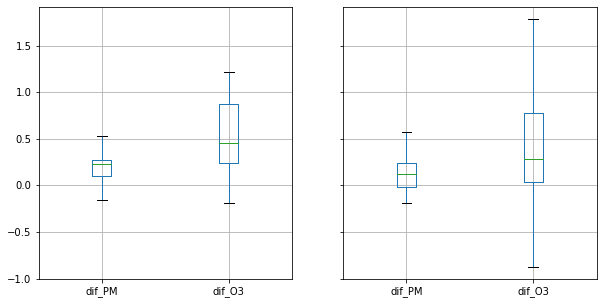

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = False, sharey = True, figsize = [10,5])
nuclear_df.boxplot(column = ['dif_PM','dif_O3'], ax = ax1, showfliers=False)
no_nuclear_df.boxplot(column = ['dif_PM','dif_O3'], ax = ax2, showfliers=False)
print(nuclear_df['dif_PM'].median(),no_nuclear_df['dif_PM'].median())
print(nuclear_df['dif_O3'].median(),no_nuclear_df['dif_O3'].median())

In [51]:
#normal and nonuc concentrations
for race in np.unique(mort_df['Race/Hispanic Origin']):
    for poll in ['O3','PM25']:
        print(race, poll, 'normal', full_df.xs(race, level =2)[f'normal_{poll}'].mean())
        print(race, poll, 'No nuclear', full_df.xs(race, level =2)[f'nonuc_{poll}'].mean())

American Indian or Alaska Native O3 normal 43.644276291362836
American Indian or Alaska Native O3 No nuclear 43.790840326901304
American Indian or Alaska Native PM25 normal 6.2491633811639975
American Indian or Alaska Native PM25 No nuclear 6.272666611792289
Asian or Pacific Islander O3 normal 44.599949543638814
Asian or Pacific Islander O3 No nuclear 44.97282545392284
Asian or Pacific Islander PM25 normal 7.984671523419585
Asian or Pacific Islander PM25 No nuclear 8.099072807072885
Black or African American O3 normal 45.17900143627593
Black or African American O3 No nuclear 45.81326458728589
Black or African American PM25 normal 8.076283687164995
Black or African American PM25 No nuclear 8.24902496279113
Hispanic or Latino O3 normal 44.73138024354028
Hispanic or Latino O3 No nuclear 45.035673088042564
Hispanic or Latino PM25 normal 7.15239132464183
Hispanic or Latino PM25 No nuclear 7.226095443110602
Not Hispanic or Latino O3 normal 45.09620402845949
Not Hispanic or Latino O3 No nucle

In [52]:
print(full_df.xs('White', level =2)['normal_PM25'].mean())
print(full_df.xs('White', level =2)['nonuc_PM25'].mean())

7.555062281703513
7.696871582990362


In [53]:
print(full_df.xs('Black or African American', level =2)['normal_PM25'].mean())
print(full_df.xs('Black or African American', level =2)['nonuc_PM25'].mean())

8.076283687164995
8.24902496279113
